In [1]:
import GPyOpt
import GPy
import numpy as np

## 1. First Reaction

In [36]:
#Set up test function
n_descriptors = 3
seed = np.random.RandomState(100)
solvents = seed.rand(400, n_descriptors)

class Reaction:
    def __init__(self, a, b, c):
        self._a = a
        self._b = b
        self._c = c
        
    def f(self, X):
        noise = 0.001*np.random.randn(X.shape[0])
        y = self._a*X[:, 0]**2 + self._b*X[:, 1]**1.1 + self._c*X[:, 2] + noise
        return np.atleast_2d(y).T

first_exp_conditions = solvents[seed.randint(1, 400, 40), :]
r1 = Reaction(0.1, 0.5, 0.001)
first_exp_results = r1.f(first_exp_conditions)

In [46]:
kern_1 = GPy.kern.Matern52(input_dim=n_descriptors, variance=1., ARD=True)
kern_1

Mat52.,value,constraints,priors
variance,1.0,+ve,
lengthscale,"(3,)",+ve,


In [47]:
m1 = GPy.models.GPRegression(X=first_exp_conditions, Y=first_exp_results, kernel=kern_1)
m1

GP_regression.,value,constraints,priors
Mat52.variance,1.0,+ve,
Mat52.lengthscale,"(3,)",+ve,
Gaussian_noise.variance,1.0,+ve,


In [48]:
m1.optimize_restarts(num_restarts=10)

Optimization restart 1/10, f = -180.8148516202537
Optimization restart 2/10, f = -155.8018032834013
Optimization restart 3/10, f = -180.8148516556106
Optimization restart 4/10, f = -180.81485161751095
Optimization restart 5/10, f = -180.8148515572271
Optimization restart 6/10, f = -180.66174613592557
Optimization restart 7/10, f = -180.8148516378508
Optimization restart 8/10, f = -155.80186229395434
Optimization restart 9/10, f = -180.81485164492614
Optimization restart 10/10, f = -180.81485164898407


In [54]:
m1.kern.lengthscale.values

array([   9.01118965,    7.31113876, 1961.63069233])

In [33]:
m1.log_likelihood()

169.95030235719545

## 2. Second Reaction

In [113]:
#Second similar reaction
r2 = Reaction(0.13, 0.45, 0.02)
def inverse(X):
    y = r2.f(X)
    return y**(-1)
objective = GPyOpt.core.task.SingleObjective(inverse)
variables = [{'name': 'solvent', 'type': 'bandit', 'domain':solvents}]
domain = GPyOpt.Design_space(variables)
lhs = GPyOpt.experiment_design.initial_design('latin', domain, 10)

In [136]:
kerns_2 = 2*[]
kerns_2 = [GPy.kern.Matern52(input_dim=3, variance=1., ARD=True) for _ in range(2)]
# kerns_2[1].lengthscale.set_prior(GPy.priors.StudentT(0.5,0.1,0.1))

In [129]:
models = [GPyOpt.models.GPModel(kernel=kern, optimize_restarts=5, verbose=False) 
          for kern in kerns_2]

In [130]:
acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(domain)
acquisitions = [GPyOpt.acquisitions.AcquisitionEI(model, domain, optimizer=acquisition_optimizer) 
                for model in models]


In [131]:
evaluators = [GPyOpt.core.evaluators.Sequential(acquisition) for acquisition in acquisitions]

In [132]:
bos = [GPyOpt.methods.ModularBayesianOptimization(model, 
                                                  domain, 
                                                  objective, 
                                                  acquisition, 
                                                  evaluator, 
                                                  lhs)
      for model, acquisition, evaluator
      in zip(models, acquisitions, evaluators)]

In [133]:
max_iter = 10
for bo in bos:
    bo.run_optimization(max_iter=max_iter)

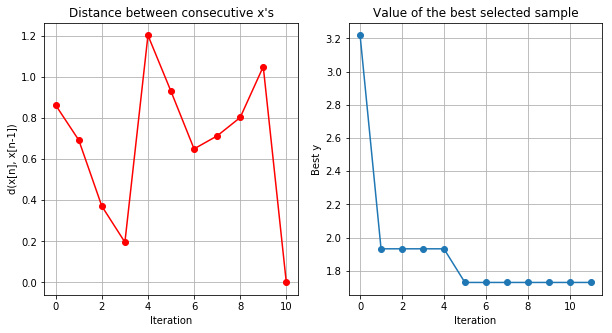

In [134]:
bos[0].plot_convergence()

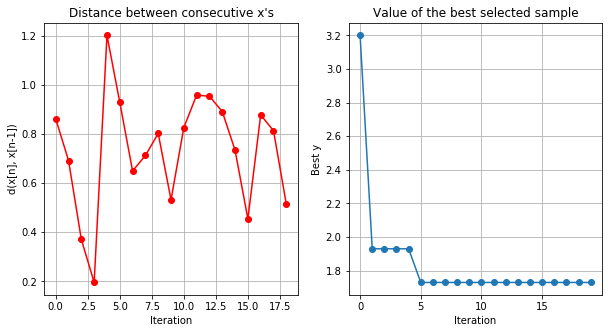

In [135]:
bos[1].plot_convergence()